This is a continuation of the Mie Scattering notebook. I created this second notebook because the first one has gotten very long, so it is more convenient this way.

In [1]:
# All of the imports and basic functions from the Mie Scattering notebook
import scipy.special as fn
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from time import sleep
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

#Define functions for S_n(z), C_n(z), Φ_n(z), and their derivatives (derivatives denoted with a "d")

def S(n,z):
    return np.sqrt(np.pi/2*z)*fn.jv(n+1/2,z)  # fn.jv(k,z) is the Bessel function J_k(z)

def dS(n,z):
    v = n+1/2
    s = np.sqrt(np.pi/2*z)*fn.jvp(v,z)    # fn.jvp(k,z) is the derivative of the Bessel function (wrt z)
    t = np.sqrt(np.pi/(2*z))/2*fn.jv(v,z)
    return s+t

def C(n,z):
    v = n+1/2
    return (-1)**n*np.sqrt(np.pi/2*z)*fn.jv(-v,z)

def dC(n,z):
    v = n+1/2
    s = np.sqrt(np.pi/2*z)*fn.jvp(-v,z)
    t = 0.5*np.sqrt(np.pi/(2*z))*fn.jv(-v,z)
    return (-1)**n*(s+t)

def phi(n,z):
    return S(n,z)+1j*C(n,z)

def dphi(n,z):
    return dS(n,z)+1j*dC(n,z)

#Now I define functions for a_n and b_n and a function for the nth term in the infinite series in the expression
# for the cross section.
#l is λ₀, r & m represent the same things as above.

def a_n(n,l,r,m):
    alpha = 2*np.pi*r/l
    beta = m*alpha
    top = S(n,alpha)*dS(n,beta)-m*S(n,beta)*dS(n,alpha)
    bot = dS(n,beta)*phi(n,alpha)-m*S(n,beta)*dphi(n,alpha)
    return (-1)**(n+1/2)*top/bot

def b_n(n,l,r,m):
    alpha = 2*np.pi*r/l
    beta = m*alpha
    top = m*S(n,alpha)*dS(n,beta)-S(n,beta)*dS(n,alpha)
    bot = m*dS(n,beta)*phi(n,alpha)-S(n,beta)*dphi(n,alpha)
    return (-1)**(n+3/2)*top/bot

def term(n,l,r,m):
    return (2*n+1)*(abs(a_n(n,l,r,m))**2+abs(b_n(n,l,r,m))**2)

#This function calculates the cross section. l is λ₀, r & m represent the same things as above.
def cs(l,r,m):
    total = 0  #I use a while loop to add up the infinite sum
    nterm = 1
    n=1
    while np.all(abs(nterm) >= 1e-35): #By the time the terms get this small, the sum has already converged to the answer.
        nterm = term(n,l,r,m)
        n+=1
        total+=nterm
    return l**2/2/np.pi*total

#function for transmission. lam = λ₀, Ka & Ks are K_2^a & K_2^s, other variable names are the same as above
def trans(lam,K1,Ka,l,Ns,r,m):
    Ks = cs(lam,r,m)*Ns
    T = np.exp(-(K1+Ka+Ks)*l)
    return T

I will still be using the bubble model, where the extinction coefficients due to absorbtion are assumed to be negligible, the path length is 100 microns, and the impurities (spheres) have a refractive index of 1. However, the value of $m$ also depends on the refractive index of the medium, which varies based on material, temperature, and wavelength. The values of refractive index used in this section come from the *Physical Review* paper **"Refractive Indices of the Condensed Inert Gases"** (Sinnock and Smith, 1969). These first two cells are for Argon films.

Text(0, 0.5, 'Refractive Index')

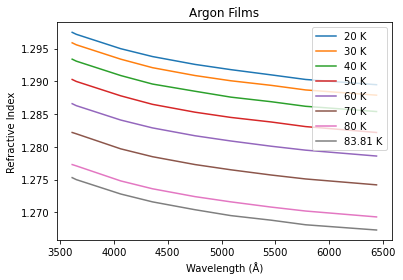

In [2]:
ararr=np.array([[1.2895, 1.2903, 1.291 , 1.2918, 1.2926, 1.2938, 1.295 , 1.2972,1.2975],
       [1.2879, 1.2887, 1.2894, 1.2901, 1.2909, 1.2921, 1.2934, 1.2956,1.2959],
       [1.2854, 1.2862, 1.2869, 1.2876, 1.2885, 1.2896, 1.2909, 1.2931,1.2934],
       [1.2822, 1.2831, 1.2838, 1.2845, 1.2853, 1.2865, 1.2878, 1.29  ,1.2903],
       [1.2786, 1.2795, 1.2801, 1.2809, 1.2817, 1.2829, 1.2841, 1.2863,1.2866],
       [1.2742, 1.2751, 1.2757, 1.2765, 1.2773, 1.2785, 1.2797, 1.282 ,1.2822],
       [1.2693, 1.2702, 1.2708, 1.2716, 1.2724, 1.2736, 1.2748, 1.2771,1.2773],
       [1.2673, 1.2681, 1.2688, 1.2695, 1.2704, 1.2716, 1.2728, 1.275 ,1.2753]])
wls = [6439, 5780, 5461, 5086, 4753, 4358, 4063, 3650,3612]
count = 2
for i in ararr:
    count = min(count,8.381)
    plt.plot(wls, i, label = '{} K'.format(count*10))
    count+=1
plt.legend()
plt.title("Argon Films")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Refractive Index")

Text(0, 0.5, 'Refractive Index')

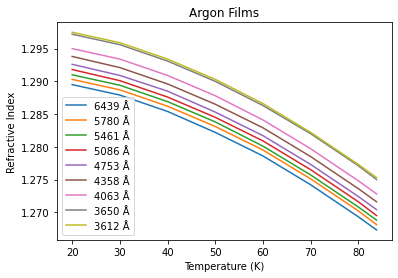

In [3]:
ararr2 = np.transpose(ararr)
count = 0
tempr = np.array([20,30,40,50,60,70,80,83.81])
for i in ararr2:
    plt.plot(tempr, i, label = "{} Å".format(wls[count]))
    count+=1
plt.legend()
plt.title("Argon Films")
plt.xlabel("Temperature (K)")
plt.ylabel("Refractive Index")

First, I will try to give a fit for the temperature dependence. I will hold the wavelength constant for each fit. The first function defined here is an empirical fit to a generalised logistic function, which I used because the refractive index must stay above 1, so, based on the values in the graph, it looked like the overall curve should have a sigmoid shape (and a regular logistic functio didn't give a good fit).

In [119]:
def refr(temp,K,Q,B,v):
    return 1+K/(1+Q*np.exp(B*temp))**v

In [77]:
curves = []
pops = []
long = np.linspace(0,100,20)
for i in ararr2:
    popt = curve_fit(refr,tempr,i,[.3,1,1,.5])[0]
    pops.append(popt)
    #curves.append(refr(long,*popt))
    curves.append(refr(tempr,*popt))

I defined a new refr function with fewer parameters and that was less arbitrary than the previous one. The original idea was to use a first-order approximation of thermal expansion, $l_T=(1+aT)l_0$, where $l_T$ is the length of a solid at temperature $T$ (in Kelvin), $l_0$ is the length at absolute zero, and $a$ is a constant. Since the volume $V_T$ is proportional to $l_T^3$, $V\propto (1+aT)^3$. The number density $\rho_T$ is proportional to $1/V_t$, so $\rho_T\propto\frac{1}{(1+aT)^3}$. The refractive index $n$ can be found by the formula $n=\sqrt{1+\alpha\rho_T}=\sqrt{1+\frac{b}{(1+aT)^3}}$, where $\alpha$ is the polarizability of the material, which is constant, and $b$ is another constant. This approximation, however, was not successful at fitting the data because it always gives a convex function (when the parameters are positive), while the function for temperature dependence is clearly concave in the region tested. When the parameters are negative, the function is increasing, so even that doesn't give a good fit. Therefore, I used a second-order approximation for thermal expansion, rather than a first-order one and added an extra parameter $c$. The approximation for thermal expansion is now $l_T\propto1+aT+cT^2$, which yields a final result for refractive index of $n=\sqrt{1+\frac{b}{(1+aT+cT^2)^3}}$.

In [16]:
def refr(temp,a,b,c):
    return (1+b/(1+a*temp+c*temp**2)**3)**0.5

In [6]:
long = np.linspace(0,100,100)
l2 = refr(long,.00002,100)
plt.plot(long,l2)

TypeError: refr() missing 1 required positional argument: 'c'

In [5]:
curves = []
pops = []
long = np.linspace(0,100,20)
for i in ararr2:
    popt = curve_fit(refr,tempr,i,[.1,.5,.1])[0]
    pops.append(popt)
    #curves.append(refr(long,*popt))
    curves.append(refr(tempr,*popt))

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


RMSE = 0.00011484279958987722
a = -1.0906350044726644e-05 b = 0.686117571067131 c = 4.570070055560333e-06


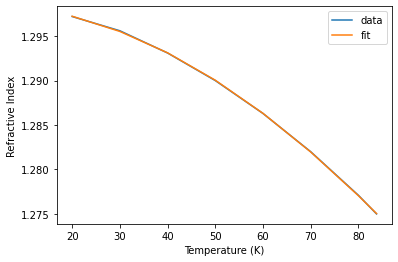

KeyboardInterrupt: 

In [6]:
# This will show the actual and best fit plots for value of wavelength in sequence
for i in range(len(ararr2)):
    plt.plot(tempr,ararr2[i],label='data')
    #plt.plot(long,curves[i])
    plt.plot(tempr,curves[i],label='fit')
    RMSE = sum((curves[i]-ararr2[i])**2)**0.5 # root mean squared error
    print('RMSE =',RMSE)
    print('a =',pops[i][0],'b =',pops[i][1],'c =',pops[i][2]) # pints values of parameters
    plt.legend()
    plt.xlabel("Temperature (K)")
    plt.ylabel("Refractive Index")
    plt.show()
    sleep(1)
    clear_output(wait=True)

In [61]:
pops

[array([-6.53358746e-06,  6.66383959e-01,  4.65564988e-06]),
 array([-1.71911330e-05,  6.68012440e-01,  4.72803723e-06]),
 array([-1.17700679e-05,  6.70066991e-01,  4.68352821e-06]),
 array([-8.62986010e-06,  6.72111005e-01,  4.63818318e-06]),
 array([-7.23829550e-06,  6.74269887e-01,  4.60768059e-06]),
 array([-3.69536065e-06,  6.77465523e-01,  4.55200053e-06]),
 array([-1.10937433e-05,  6.80437901e-01,  4.61804729e-06]),
 array([-1.09063500e-05,  6.86117571e-01,  4.57007006e-06]),
 array([-1.06871004e-05,  6.86935788e-01,  4.57811120e-06])]

Now, we will look at the same thing for Krypton films.

Text(0, 0.5, 'Refractive Index')

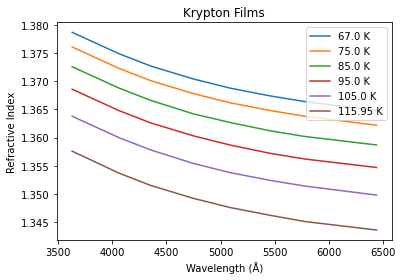

In [4]:
krarr = np.array([[1.3648, 1.3664, 1.3674, 1.3688, 1.3704, 1.3727, 1.3749, 1.3787],
       [1.3622, 1.3638, 1.3648, 1.3662, 1.3678, 1.3701, 1.3723, 1.3761],
       [1.3587, 1.3602, 1.3612, 1.3627, 1.3642, 1.3666, 1.3688, 1.3726],
       [1.3547, 1.3562, 1.3572, 1.3587, 1.3603, 1.3626, 1.3648, 1.3686],
       [1.3498, 1.3514, 1.3524, 1.3538, 1.3554, 1.3578, 1.36  , 1.3638],
       [1.3436, 1.3451, 1.3462, 1.3476, 1.3492, 1.3515, 1.3537, 1.3576]])
ang = np.array([6439, 5780, 5461, 5086, 4753, 4358, 4063, 3631])
temps = np.array([67,75,85,95,105,115.95])
for i in range(6):
    count = min(count,8.381)
    plt.plot(ang, krarr[i], label = '{} K'.format(temps[i]))
plt.legend()
plt.title("Krypton Films")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Refractive Index")

Text(0, 0.5, 'Refractive Index')

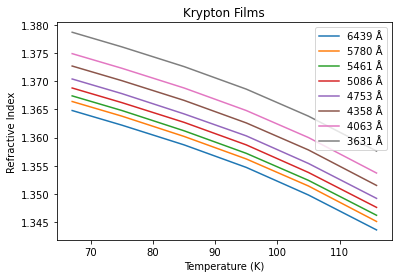

In [5]:
krarr2 = np.transpose(krarr)
count = 0
for i in krarr2:
    plt.plot(temps, i, label = "{} Å".format(ang[count]))
    count+=1
plt.legend()
plt.title("Krypton Films")
plt.xlabel("Temperature (K)")
plt.ylabel("Refractive Index")

In [8]:
curves = []
pops = []
long = np.linspace(0,100,20)
for i in krarr2:
    popt = curve_fit(refr,temps,i,[.01,.4,.01])[0]
    pops.append(popt)
    #curves.append(refr(long,*popt))
    curves.append(refr(temps,*popt))

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


RMSE = 0.0002833347943541644
a = -0.00022873313739505733 b = 0.9042205704135776 c = 3.7214518227361464e-06


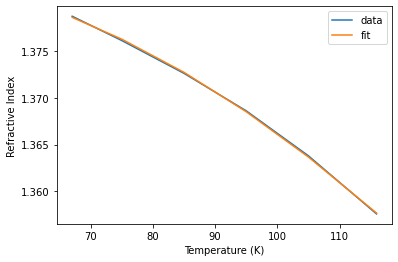

In [109]:
for i in range(len(krarr2)):
    plt.plot(temps,krarr2[i],label='data')
    #plt.plot(long,curves[i])
    plt.plot(temps,curves[i],label='fit')
    RMSE = sum((curves[i]-krarr2[i])**2)**0.5
    print('RMSE =',RMSE)
    print('a =',pops[i][0],'b =',pops[i][1],'c =',pops[i][2])
    plt.legend()
    plt.xlabel("Temperature (K)")
    plt.ylabel("Refractive Index")
    plt.show()
    sleep(1)
    clear_output(wait=True)

Now I want a function that fits both the wavelength and temperature dependence at once. The wavelength dependence is given approximately by $n_\lambda=A+\frac{B}{\lambda^2}+\frac{C}{\lambda^4}$. (This formula can be found in the *Jounal of Applied Physics* paper **"Rayleigh, Mie, and Tyndall scatterings of polystyrene microspheres in water: Wavelength, size, and angle dependences"** (He et al, 2009)). I tried combining this with the previous formula by dividing it by $A$ and multiplying the result by the temperature dependence formula, so that the temperature dependence formula would act as a constant when varying wavelength.

In [15]:
def ultref1(X,a,b,c,d,e,f):
    temp,wavl=X #These are combined into one function parameter so that curve_fit can be used
    tempdep = refr(temp,a,b,c)
    wavdep = d+e/wavl**2+f/wavl**4
    return tempdep*wavdep

In [7]:
# This gives an array of all combinations of temperature and wavelength for which the refractive index was measured
X = np.array([np.array([[i,j] for i in temps]) for j in ang])

In [11]:
np.shape(X)

(8, 6, 2)

I want to separate the values for wavelength and temperature, since the function uses them both separately. The array defined above can be thought of as a matrix of ordered pairs of wavelength and temperature, but it is really a 3D array with the last axis being one that lets you switch between wavelength and temperature. I need to switch these around by taking the transpose of the array.

In [8]:
Y=np.transpose(X)

In [9]:
# Now we can see that the array separates out into temperature and wavelength parts
x,y = Y
x,y

(array([[ 67.  ,  67.  ,  67.  ,  67.  ,  67.  ,  67.  ,  67.  ,  67.  ],
        [ 75.  ,  75.  ,  75.  ,  75.  ,  75.  ,  75.  ,  75.  ,  75.  ],
        [ 85.  ,  85.  ,  85.  ,  85.  ,  85.  ,  85.  ,  85.  ,  85.  ],
        [ 95.  ,  95.  ,  95.  ,  95.  ,  95.  ,  95.  ,  95.  ,  95.  ],
        [105.  , 105.  , 105.  , 105.  , 105.  , 105.  , 105.  , 105.  ],
        [115.95, 115.95, 115.95, 115.95, 115.95, 115.95, 115.95, 115.95]]),
 array([[6439., 5780., 5461., 5086., 4753., 4358., 4063., 3631.],
        [6439., 5780., 5461., 5086., 4753., 4358., 4063., 3631.],
        [6439., 5780., 5461., 5086., 4753., 4358., 4063., 3631.],
        [6439., 5780., 5461., 5086., 4753., 4358., 4063., 3631.],
        [6439., 5780., 5461., 5086., 4753., 4358., 4063., 3631.],
        [6439., 5780., 5461., 5086., 4753., 4358., 4063., 3631.]]))

In [10]:
# This creates an array like Y, except that the two components are 1D instead of 2D, which is useful for curve_fit
Z = np.array([x.flatten(),y.flatten()])
Z

array([[  67.  ,   67.  ,   67.  ,   67.  ,   67.  ,   67.  ,   67.  ,
          67.  ,   75.  ,   75.  ,   75.  ,   75.  ,   75.  ,   75.  ,
          75.  ,   75.  ,   85.  ,   85.  ,   85.  ,   85.  ,   85.  ,
          85.  ,   85.  ,   85.  ,   95.  ,   95.  ,   95.  ,   95.  ,
          95.  ,   95.  ,   95.  ,   95.  ,  105.  ,  105.  ,  105.  ,
         105.  ,  105.  ,  105.  ,  105.  ,  105.  ,  115.95,  115.95,
         115.95,  115.95,  115.95,  115.95,  115.95,  115.95],
       [6439.  , 5780.  , 5461.  , 5086.  , 4753.  , 4358.  , 4063.  ,
        3631.  , 6439.  , 5780.  , 5461.  , 5086.  , 4753.  , 4358.  ,
        4063.  , 3631.  , 6439.  , 5780.  , 5461.  , 5086.  , 4753.  ,
        4358.  , 4063.  , 3631.  , 6439.  , 5780.  , 5461.  , 5086.  ,
        4753.  , 4358.  , 4063.  , 3631.  , 6439.  , 5780.  , 5461.  ,
        5086.  , 4753.  , 4358.  , 4063.  , 3631.  , 6439.  , 5780.  ,
        5461.  , 5086.  , 4753.  , 4358.  , 4063.  , 3631.  ]])

In [11]:
# This function will do what I did above to create the Y and Z arrays automatically
def splice(arr1,arr2):
    X = np.array([np.array([[i,j] for i in arr1]) for j in arr2])
    Y=np.transpose(X)
    x,y = Y
    Z = np.array([x.flatten(),y.flatten()])
    return Y, Z

In [16]:
splice(temps,ang)[0]

array([[[  67.  ,   67.  ,   67.  ,   67.  ,   67.  ,   67.  ,   67.  ,
           67.  ],
        [  75.  ,   75.  ,   75.  ,   75.  ,   75.  ,   75.  ,   75.  ,
           75.  ],
        [  85.  ,   85.  ,   85.  ,   85.  ,   85.  ,   85.  ,   85.  ,
           85.  ],
        [  95.  ,   95.  ,   95.  ,   95.  ,   95.  ,   95.  ,   95.  ,
           95.  ],
        [ 105.  ,  105.  ,  105.  ,  105.  ,  105.  ,  105.  ,  105.  ,
          105.  ],
        [ 115.95,  115.95,  115.95,  115.95,  115.95,  115.95,  115.95,
          115.95]],

       [[6439.  , 5780.  , 5461.  , 5086.  , 4753.  , 4358.  , 4063.  ,
         3631.  ],
        [6439.  , 5780.  , 5461.  , 5086.  , 4753.  , 4358.  , 4063.  ,
         3631.  ],
        [6439.  , 5780.  , 5461.  , 5086.  , 4753.  , 4358.  , 4063.  ,
         3631.  ],
        [6439.  , 5780.  , 5461.  , 5086.  , 4753.  , 4358.  , 4063.  ,
         3631.  ],
        [6439.  , 5780.  , 5461.  , 5086.  , 4753.  , 4358.  , 4063.  ,
         3631.  

In [23]:
np.shape(krarr)

(6, 8)

In [14]:
# a 1D array to use together with Z. It has the same shape as each of the elements in Z
W = krarr.flatten()

In [17]:
popt = curve_fit(ultref1,Z,W,[.001,.4,.001,.1,1e6,1e24])[0]

C:\Users\jrnoo\Anaconda\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [26]:
popt

array([-3.94287450e+01,  6.98387865e+02, -5.35215520e-01,  1.34838545e+00,
        3.05171152e+05, -3.33443854e+11])

In [18]:
fit = ultref1(Y,*popt)

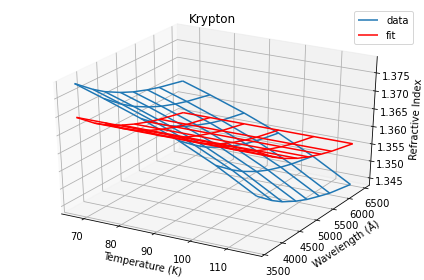

In [19]:
#creates a 3D plot of results
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(x,y,krarr,label='data')
ax.plot_wireframe(x,y,fit,color='r',label='fit')
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
ax.set_zlabel('Refractive Index')
plt.title('Krypton')
plt.legend()
plt.tight_layout()

The fit didn't work very well, no matter what starting parameters I used. To solve this, I decided to look at how the refractive indices for different wavelengths compare with each other. In the previous graphs it looked like the differences between refractive indices at two different wavelengths remained constant with temperature, even though the individual refractive indices at each wavelength did not. To confirm this, I made a graph of the relative refractive index, which is just the efractive index of krypton at a given wavelength and temperature, minus the refractive index at the same temperature for a wavelength of 6439 Å.

Text(0, 0.5, 'Relative Refractive Index')

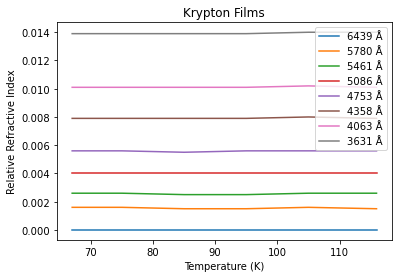

In [20]:
krarr2 = np.transpose(krarr)
count = 0
for i in krarr2:
    plt.plot(temps, (i-krarr2[0]), label = "{} Å".format(ang[count]))
    count+=1
plt.legend()
plt.title("Krypton Films")
plt.xlabel("Temperature (K)")
plt.ylabel("Relative Refractive Index")

The relative refractive indices are indeed approximately constant for each value of wavelength. This implies that there should be an additive term (rather than a multiplicative factor) that depends on wavelength in the refractive index function. In the graph below, I took the average relative refractive index for each wavelength (averaged across all measured temperatures).

Text(0, 0.5, 'Relative Refractive Index')

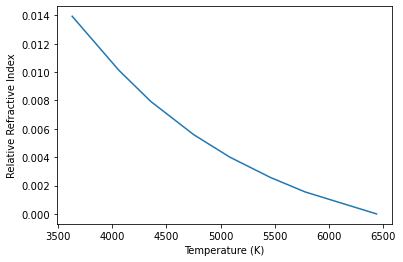

In [21]:
diffs = []
for i in krarr2:
    diffs.append(sum(i-krarr2[0])/len(i))
plt.plot(ang,diffs)
plt.xlabel("Temperature (K)")
plt.ylabel("Relative Refractive Index")

I fit the curve above to the function for refractive index in terms of wavelength. I have removed the term containing $\lambda^{-4}$ because it was not necessary to get a good fit, so the second-order approximation works fine. Using a simpler approximation will help to avoid overfitting, which is a real issue here since there are so few data points and multiple free parameters.

In [21]:
def ind(wav,A,B):
    return A+B/wav**2

In [22]:
riparms = curve_fit(ind,ang,diffs,[1,.1])[0]
riparms

NameError: name 'diffs' is not defined

Note: The negative value of $A$ makes sense here because $A=\lim_{\lambda\to\infty}(n_\lambda-n_{6439 Å})$, and the refractive index is decreasing with wavelength, so $n_\lambda$ will be smaller than $n_{6439 Å}$ for values of $\lambda$ larger than 6439 $Å$.

0.00010132026748355401

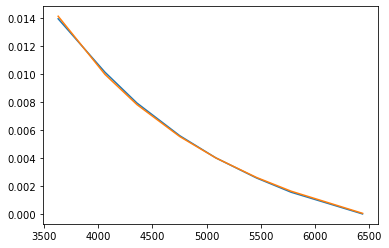

In [33]:
#Best fit plot for the curve above
fit = ind(ang,*riparms)
plt.plot(ang,diffs)
plt.plot(ang,fit)
RMSE = (sum((diffs-fit)**2)/len(ang))**0.5
RMSE

This is the new version of the wavelength and temperature dependent function.

In [23]:
def ultref(X,a,b,c,A,B):
    temp,wavl=X
    tempdep = refr(temp,a,b,c)
    wavdep = A+B/wavl**2
    return tempdep+wavdep

In [24]:
parms = curve_fit(ultref,Z,W,[.001,.04,3e-6,.0001,1e5])[0]

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [36]:
parms

array([-2.02823499e-03, -4.20714203e-02, -2.61489404e-06,  3.92796537e-01,
        2.72062705e+05])

The fit here is extremely good, nearly perfect, as seen in the graph below. However, the negative parameters don't really make physical sense, at least, not in terms of what they were originally interpreted to mean in terms of thermal expansion coefficients. Therefore, while this is a good empirical fit, we should be careful with it.

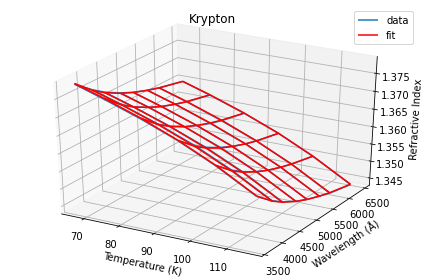

In [25]:
kfit = ultref(Y,*parms)
fig = plt.figure()
x,y = Y
ax = plt.axes(projection='3d')
ax.plot_wireframe(x,y,krarr,label='data')
ax.plot_wireframe(x,y,kfit,color='r',label='fit')
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
ax.set_zlabel('Refractive Index')
plt.legend()
plt.title('Krypton')
plt.tight_layout()

Now I plot the residuals to see if there is a pattern. The residuals are very hard to visualize using a wireframe plot, so both a surface plot and a contour plot are given.

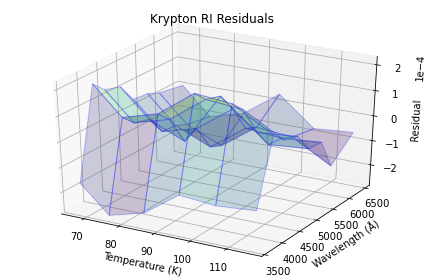

In [38]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,krarr-kfit,cmap='viridis',alpha=0.25,edgecolor='b')
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
ax.set_zlabel('Residual')
plt.title('Krypton RI Residuals')
ax.ticklabel_format(axis='z',style='sci',scilimits=(0,0))
plt.tight_layout()

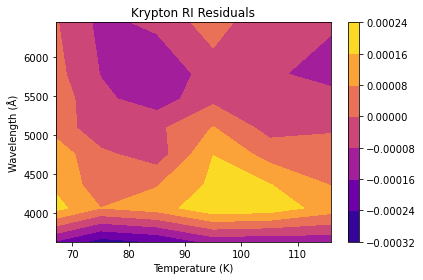

In [39]:
fig = plt.figure()
ax = plt.axes()
plot = ax.contourf(x,y,krarr-kfit,cmap='plasma')
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
plt.title('Krypton RI Residuals')
fig.colorbar(plot)
plt.tight_layout()

The root mean squared error (RMSE) of the fit is calculated below. The first value is simply the sample RMSE of the model fit compared to the data, while the second is the unbiased estimate of the RMSE, which is calculated using degrees of freedom rather than number of data points.

In [40]:
sq = sum(sum((kfit-krarr)**2))
mse = sq/np.size(krarr)
umse = sq/(np.size(krarr)-len(parms))
rmse = mse**0.5
rumse = umse**0.5
print(rmse,rumse)

0.00011500555893209039 0.00012150809831309271


This is the fit above extrapolated to values of temperature and wavelength that cover the values that were actually used in our films.

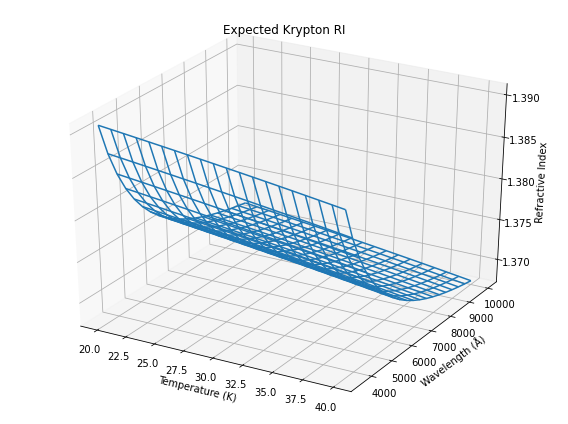

In [26]:
newtemps = np.linspace(20,40,20)
newwav = np.linspace(3500,10000,20)
vals = splice(newtemps,newwav)[0]
model = ultref(vals,*parms)
fig = plt.figure(figsize = (8,6))
ax = plt.axes(projection='3d')
ax.plot_wireframe(vals[0],vals[1],model)
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
ax.set_zlabel('Refractive Index')
plt.title('Expected Krypton RI')
plt.tight_layout()

Now I will do the fit for argon.

Text(0, 0.5, 'Relative Refractive Index')

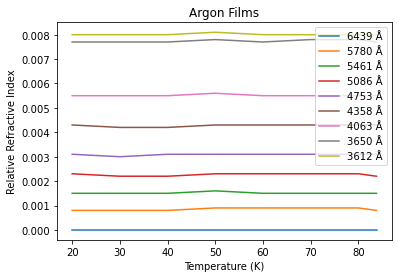

In [28]:
count = 0
for i in ararr2:
    plt.plot(tempr, (i-ararr2[0]), label = "{} Å".format(wls[count]))
    count+=1
plt.legend(loc=1)
plt.title("Argon Films")
plt.xlabel("Temperature (K)")
plt.ylabel("Relative Refractive Index")

Text(0, 0.5, 'Relative Refractive Index')

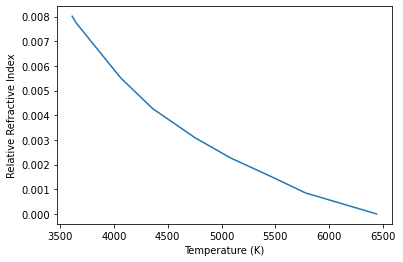

In [29]:
diffs = []
for i in ararr2:
    diffs.append(sum(i-ararr2[0])/len(i))
plt.plot(wls,diffs)
plt.xlabel("Temperature (K)")
plt.ylabel("Relative Refractive Index")

In [27]:
Y1 = splice(tempr,wls)[0]
Z1 = splice(tempr,wls)[1]
W1 = ararr.flatten()
paras = curve_fit(ultref,Z1,W1,[.001,.4,3e-6,.0001,1e5])[0]

In [31]:
paras

array([-1.29167098e-05,  6.30773716e-01,  4.92941185e-06,  1.01255347e-02,
        1.51596006e+05])

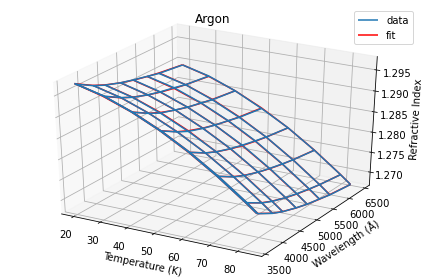

In [28]:
afit = ultref(Y1,*paras)
fig = plt.figure()
x1, y1 = Y1
ax = plt.axes(projection='3d')
ax.plot_wireframe(x1,y1,ararr,label='data')
ax.plot_wireframe(x1,y1,afit,color='r',label='fit')
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
ax.set_zlabel('Refractive Index')
plt.legend()
plt.title('Argon')
plt.tight_layout()

Just like before, the empirical fit is nearly perfect.

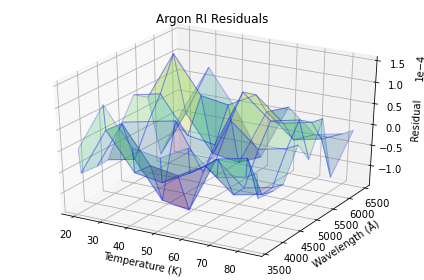

In [47]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x1,y1,ararr-afit,cmap='viridis',alpha=0.25,edgecolor='b')
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
ax.set_zlabel('Residual')
plt.title('Argon RI Residuals')
ax.ticklabel_format(axis='z',style='sci',scilimits=(0,0))
plt.tight_layout()

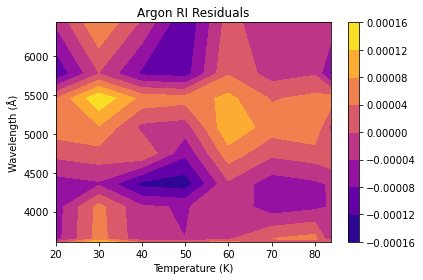

In [48]:
fig = plt.figure()
ax = plt.axes()
plot = ax.contourf(x1,y1,ararr-afit,cmap='plasma')
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
plt.title('Argon RI Residuals')
fig.colorbar(plot)
plt.tight_layout()

Again, this calculates the sample RMSE and the unbiased estimate of the RMSE.

In [49]:
sq = sum(sum((afit-ararr)**2))
mse = sq/np.size(ararr)
umse = sq/(np.size(ararr)-len(paras))
rmse = mse**0.5
rumse = umse**0.5
print(rmse,rumse)

6.0158184672678695e-05 6.236250753482359e-05


Predicted values for refractive index:

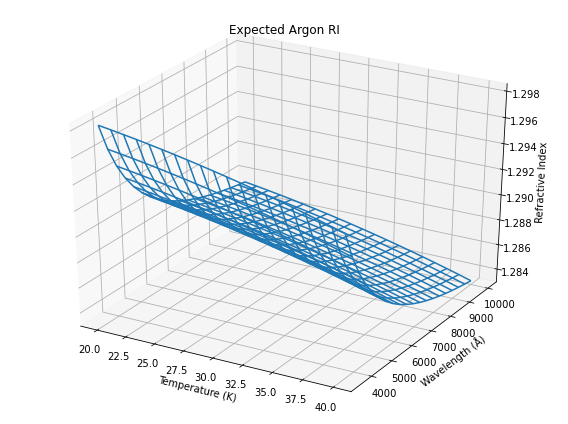

In [33]:
model1 = ultref(vals,*paras)
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.plot_wireframe(vals[0],vals[1],model1)
plt.xlabel('Temperature (K)')
plt.ylabel('Wavelength (Å)')
ax.set_zlabel('Refractive Index')
plt.title('Expected Argon RI')
plt.tight_layout()

This code defines a function that will take in the film type (krypton or argon) and the temperatures and output a function that gives the transmission of the film, assuming the bubble model, based on wavelength, number of spheres, and radius of spheres. The new function outputted has a fixed film type and temperature. This is necessary so that curve_fit will work correctly. I don't want curve fit to treat temperature as a free parameter and try to vary it because we know the temperatures of the films. I also can't use the type of film as a parameter in a function that I use curve_fit on because curve_fit requires numerical parameters.

In [29]:
Kr = 'Kr'
Ar = 'Ar'
def bubble(film,temp):
    # Based on the type of film, choose the parameters for ultref
    if film == Kr:
        putin = parms
    if film == Ar:
        putin = paras 
    # bubble is a second order function that will output a function where the film type and temperature are fixed
    def model(lam,r,Ns):
        vals = [temp, lam]
        n = ultref(vals,*putin)
        return trans(lam,0,0,100e-6,Ns,r,1/n)
    return model

The bubble model didn't work for some of the films below. One big problem is that the transmission for many of these films is greater than 1, and the bubble model can't yields transmission values gretaer than 1. This version allows for transmission>1 by assuming that whatever factor is increasing the transmission is not wavelength-dependent.

In [30]:
def Bubble(film,temp):
    def model(lam,r,Ns,const):
        return const*bubble(film,temp)(lam,r,Ns)
    return model

I will try using the updated version of the model on the same data set I analyzed in the previous notebook.

Text(0, 0.5, 'Transmission')

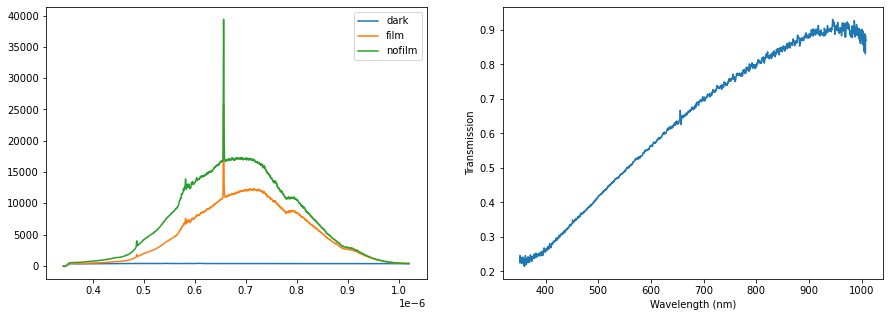

In [47]:
arr1 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_dark_FLMS138901_15-00-14-000.txt",skiprows=14)
arr2 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_film_FLMS138901_14-58-43-415.txt",skiprows=14)
arr3 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_no_film_FLMS138901_13-45-49-884.txt",skiprows=14)
wavl = arr1[:,0]*1e-9
dark = arr1[:,1]
film = arr2[:,1]
nofilm = arr3[:,1]
tr = ((film-dark)/(nofilm-dark))[24:2000]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(wavl,dark,label='dark')
plt.plot(wavl,film,label='film')
plt.plot(wavl,nofilm,label='nofilm')
plt.legend()
plt.subplot(1,2,2)
wavl = wavl[24:2000]
plt.plot(wavl*1e9,tr)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [52]:
Model = bubble(Ar,28)
popt = curve_fit(Model,wavl,tr,[1e-8,1e18])[0]
popt

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal


array([9.39470072e-08, 7.25515625e+17])

Text(0, 0.5, 'Transmission')

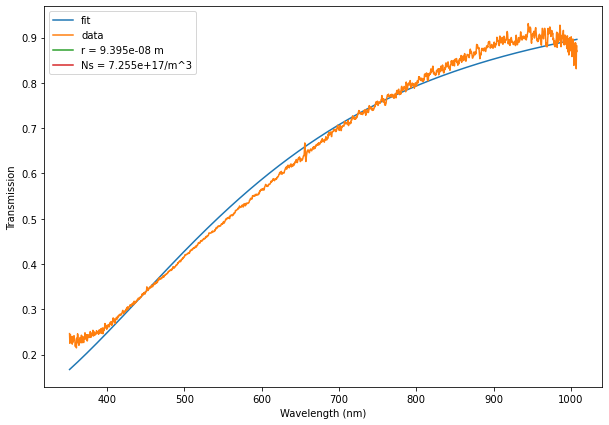

In [53]:
modelfit = Model(wavl,*popt)
plt.figure(figsize=(10,7))
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

Because the film is grown on a layer of sapphire, there will be thin film interference, which will affect the transmission. The paper <i> <b> Optical interference method for the approximate determination
of refractive index and thickness of a transparent layer </b> </i> gives a formula for the transmittance of a thick substance with a thin layer on one side:
$$T=\frac{T_1T_2}{T_1+T_2+T_1T_2},$$ where
$$T_1=\frac{8n_0n_1^2n_2}{(n_0^2+n_1^2)(n_1^2+n_2^2)+4n_0n_1^2n_2+(n_0^2-n_1^2)(n_1^2-n_2^2)\cos(2\pi n_1t_1/\lambda)},$$
$$T_2=\frac{4n_0n_2}{(n_0+n_2)^2},$$
$n_0$ is the refractive index of the surrounding medium (air), $n_1$ is the refractive index of the thin layer, $n_2$ is the refractive index of the thick layer, $t_1$ is the thickness of the thin layer, and $\lambda$ is the wavelength of light.

In [31]:
def func(x,y,z,mode): # returns (x²±y²)(y²±z²), + if mode=1, - if mode=0
    sgn = 2*mode-1 # sgn is ±1
    x, y, z = np.array([x,y,z])**2 #squares x, y, & z
    return (x+sgn*y)*(y+sgn*z)

# Function for transmittance, as given above
def Trans(lam,n0,n1,n2,t1):
    top = 8*n0*n1**2*n2
    bot = func(n0,n1,n2,1)+top/2+func(n0,n1,n2,0)*np.cos(2*np.pi*n1*t1/lam)
    T1 = top/bot
    T2 = 4*n0*n2/(n0+n2)**2
    T = T1*T2/(T1+T2-T1*T2)
    return T

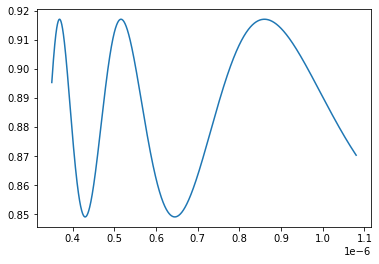

In [90]:
lam = np.linspace(350e-9,1080e-9,2048)
tra = Trans(lam,1,1.29,1.8,1e-6)
plt.plot(lam,tra)

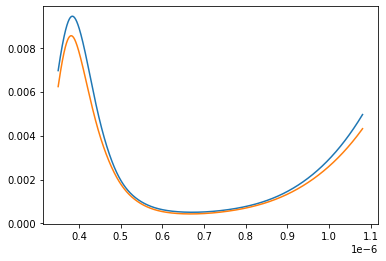

In [91]:
tra2 = bubble(Ar)(lam,1e-6,1e16)
plt.plot(lam,tra2)
plt.plot(lam,tra*tra2)

In [35]:
arr1 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_dark_FLMS138901_15-00-14-000.txt",skiprows=14)
arr2 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_film_FLMS138901_14-58-43-415.txt",skiprows=14)
arr3 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_no_film_FLMS138901_13-45-49-884.txt",skiprows=14)
wavl = arr1[:,0]*1e-9
dark = arr1[:,1]
film = arr2[:,1]
nofilm = arr3[:,1]
tr = ((film-dark)/(nofilm-dark))[24:2000]
wavl = wavl[24:2000]

In [185]:
def ref(lam,r,Ns,n2,t1):
    return bubble(Ar,28)(lam,r,Ns)*Trans(lam,1,1.29,n2,t1)

In [188]:
popt = curve_fit(ref,wavl,tr,[1.3e-7,1e18,1.5,1e-6])[0]

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [ ]:
modelfit = ref(wavl,*popt)
plt.figure(figsize=(10,7))
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.plot([],[],label='n2 = {:.3e}'.format(popt[2]))
plt.plot([],[],label='t1 = {:.3e} m'.format(popt[3]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [106]:
arr1 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190703 Ar 22K data\dark\190703_Ar_22K_dark_FLMS138901_17-07-32-813.txt",skiprows=14)
arr2 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190703 Ar 22K data\film\190703_Ar_22K_film_FLMS138901_17-06-22-722.txt",skiprows=14)
arr3 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190703 Ar 22K data\nofilm\190703_Ar_22K_no_film_FLMS138901_15-56-51-684.txt",skiprows=14)
wavl = arr1[:,0]*1e-9
dark = arr1[:,1]
film = arr2[:,1]
nofilm = arr3[:,1]
tr = ((film-dark)/(nofilm-dark))[23:]

Text(0, 0.5, 'Transmission')

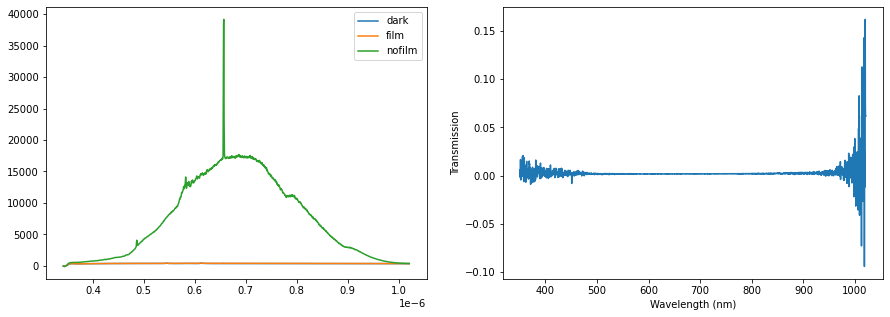

In [107]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(wavl,dark,label='dark')
plt.plot(wavl,film,label='film')
plt.plot(wavl,nofilm,label='nofilm')
plt.legend()
plt.subplot(1,2,2)
wavl = wavl[23:]
plt.plot(wavl*1e9,tr)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

The function below calculates the best fit parameters in the bubble model, given the type of film, the temperature, the array of wavelengths, and the array of transmission values. It then plots the model fit versus the actual data and returns the best fit parameters, the covariance matrix of the parameters, and the unbiased estimate of RMSE.

In [53]:
def Modelfit(film,temp,wavl,tr,guesses,size=None,const=False,scat=False):
    if const:
        model = Bubble(film,temp)
    else:
        model = bubble(film,temp)
    popt, pcov = curve_fit(model,wavl,tr,guesses)
    trfit = model(wavl,*popt)
    plt.figure(figsize=size)
    if not scat:
        plt.plot(wavl*1e9,trfit,label='fit')
        plt.plot(wavl*1e9,tr,label='data')
    if scat:
        plt.scatter(wavl*1e9,trfit,label='fit',s=1)
        plt.scatter(wavl*1e9,tr,label='data',s=1)
    plt.legend()
    plt.title("{} film, {}K".format(film, temp))
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmission")
    sq = sum((trfit-tr)**2)
    umse = sq/(len(wavl)-len(guesses))
    rumse = umse**0.5
    return popt, pcov, rumse

The function below was created for loading in the data from the files obtained from I:projects\spinlab_data\SADiCS\Oceanview on the FRIB computers. This function only works as written on my computer because the local variable "path" is the location of these files on my computer. If you are accessing these files/using this notebook on a different computer, you will have to change the path.

In [33]:
def loadin(film,temp,date,times,app="",ins="_",style=0):
    path = "C:\\Users\\jrnoo\\OneDrive\\Documents\\Mie Model\\{} {}{}\\data\\".format(film,temp,app)
    st = "_FLMS138901_"
    if style==0:
        dname = "{}_{}_{}K_dark{}{}.txt".format(date,film,temp,st,times[0])
        fname = "{}_{}_{}K_film{}{}.txt".format(date,film,temp,st,times[1])
        nname = "{}_{}_{}K_no{}film{}{}.txt".format(date,film,temp,ins,st,times[2])
    if style==1:
        dname = "{}_{}_Darkcount_{}K{}{}.txt".format(date,film,temp,st,times[0])
        fname = "{}_{}_With_Film_{}K{}{}.txt".format(date,film,temp,st,times[1])
        nname = "{}_{}_No_Film_{}K{}{}.txt".format(date,film,temp,st,times[2])
    if style==2:
        dname = "{}{}_dark{}{}.txt".format(date,ins,st,times[0])
        fname = "{}{}_film{}{}.txt".format(date,ins,st,times[1])
        nname = "{}{}_nofilm{}{}.txt".format(date,ins,st,times[2])
    arr1 = np.loadtxt(path+"dark\\"+dname,skiprows=14)
    arr2 = np.loadtxt(path+"film\\"+fname,skiprows=14)
    arr3 = np.loadtxt(path+"nofilm\\"+nname,skiprows=14)
    wavl = arr1[:,0]*1e-9
    dark = arr1[:,1]
    film = arr2[:,1]
    nofilm = arr3[:,1]
    tr = ((film-dark)/(nofilm-dark))
    return wavl, tr

This function plots the transmission values against wavelength. The values must be defined as wavl and tr before running the function in order for it to work.

In [34]:
def display():
    plt.plot(wavl*1e9,tr)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmission")

This function can be used to cut out values at the beginning and end of a list. The data for small and large wavelengths is extremely noisy, so this function can be used to cut it out.

In [35]:
def redomain(lists,st="",end=""):
    new = []
    for i in lists:
        if st=="":
            i = i[:end]
        elif end=="":
            i = i[st:]
        else:
            i = i[st:end]
        new.append(i)
    return new

Here, I have loaded in all of the data files. Some of the films seem to be pretty much opaque (constant transmission of 0), and thus the bubble model isn't applicable, but some of the films are able to be fit to the bubble model.

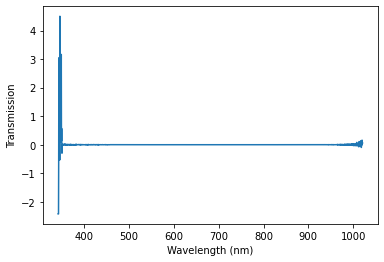

In [121]:
times = ["17-07-32-813","17-06-22-722","15-56-51-684"]
wavl, tr = loadin(Ar,22,190703,times)
display()

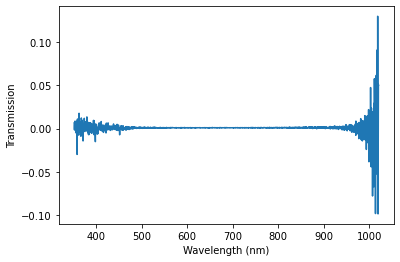

In [122]:
times = ["13-19-08-236","13-18-13-163","11-39-24-612"]
wavl, tr = loadin(Ar,22,190703,times," bad")
wavl, tr = redomain([wavl, tr],st=24)
display()

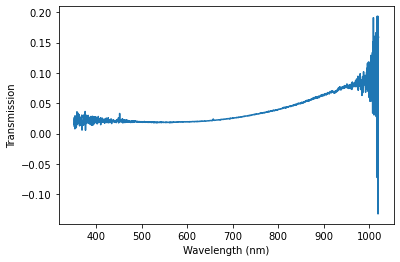

In [106]:
times = ["13-56-32-591","13-53-32-321","12-34-15-341"]
wavl, tr = loadin(Ar,24,190708,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

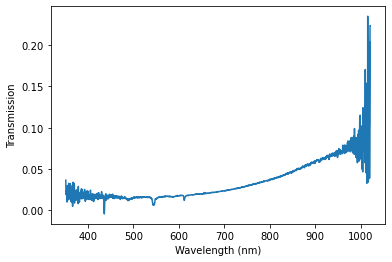

In [107]:
times = ["14-12-33-673","13-53-56-495","12-35-11-928"]
wavl, tr = loadin(Ar,24,190715,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

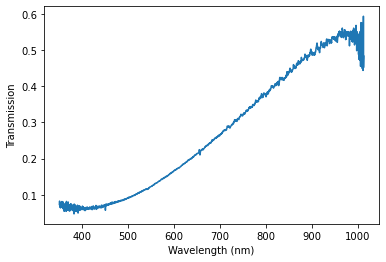

In [38]:
times = ["13-11-20-999","13-09-30-240","11-57-56-400"]
wavl, tr = loadin(Ar,25,190724,times)
wavl, tr = redomain([wavl, tr],24,2020)
display()

(array([1.66508134e-07, 2.10260514e+17]), array([[ 2.86215719e-19, -1.49009413e+06],
       [-1.49009413e+06,  7.82169614e+30]]), 0.01667563181005145)


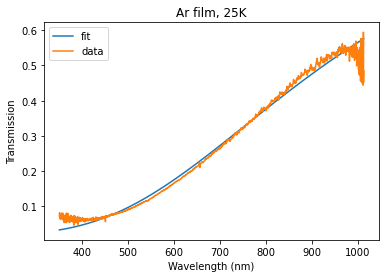

In [39]:
a = Modelfit(Ar,25,wavl,tr,[1e-7,1e18])
print(a)

[1.71694884e-07 1.91132202e+17 1.03122759e+00] [[ 2.00186531e-18 -7.05845248e+06  1.11676571e-11]
 [-7.05845248e+06  2.52660891e+31 -3.75630346e+13]
 [ 1.11676571e-11 -3.75630346e+13  7.22941031e-05]] 0.016624192321025126


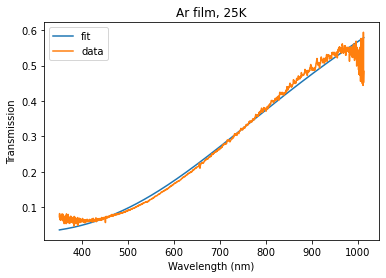

In [40]:
a,b,c = Modelfit(Ar,25,wavl,tr,[1e-7,1e18,1],const=True)
print(a,b,c)

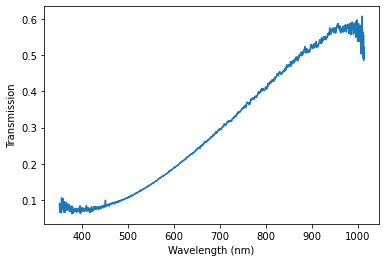

In [43]:
times = ["13-47-57-541","13-46-42-088","12-37-07-018"]
wavl1, tr1 = loadin(Ar,25,190729,times,"(1)")
wavl1, tr1 = redomain([wavl1, tr1],24,2020)
display()

[1.62976485e-07 2.11082897e+17] [[ 2.29047773e-19 -1.22400711e+06]
 [-1.22400711e+06  6.59830246e+30]] 0.015889040731075135


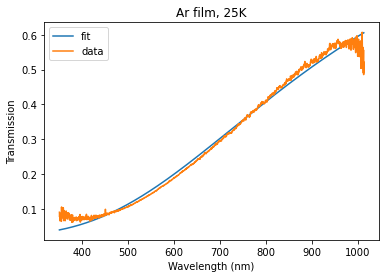

In [52]:
a,b,c = Modelfit(Ar,25,wavl1,tr1,[1e-7,1e18])
print(a,b,c)

(array([1.75799804e-07, 1.67396301e+17, 1.07759484e+00]),
 array([[ 2.78123116e-19, -8.13596152e+05,  1.61658544e-12],
        [-8.13596152e+05,  2.42379154e+30, -4.48321436e+12],
        [ 1.61658544e-12, -4.48321436e+12,  1.09884436e-05]]),
 0.015432317095281228)

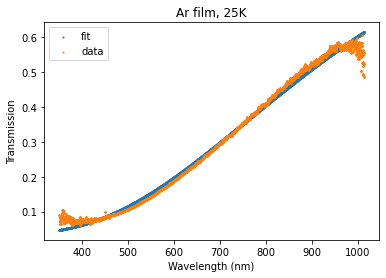

In [54]:
parlist = []
wavl = np.concatenate((wavl,wavl1))
tr = np.concatenate((tr,tr1))
par = Modelfit(Ar,25,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


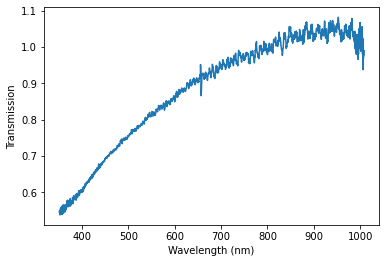

In [56]:
times = ["11-55-49-453","11-54-08-870","10-34-42-402"]
wavl, tr = loadin(Ar,26,190717,times)
wavl, tr = redomain([wavl, tr],st=24,end=2000)
display()

[3.99267276e-08 1.45110856e+19] [[ 2.70079065e-18 -5.27369059e+09]
 [-5.27369059e+09  1.03074855e+37]] 0.04276208831521631


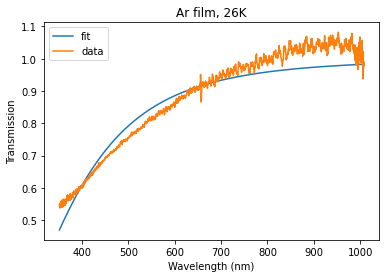

In [47]:
a,b,c = Modelfit(Ar,26,wavl,tr,[1e-7,1e18])
print(a,b,c)

[1.08949767e-07 1.76516862e+17 1.11969546e+00] [[ 9.00235609e-19 -5.41376253e+06  1.25787855e-12]
 [-5.41376253e+06  3.27639851e+31 -7.32246777e+12]
 [ 1.25787855e-12 -7.32246777e+12  2.21348412e-06]] 0.015006678268960868


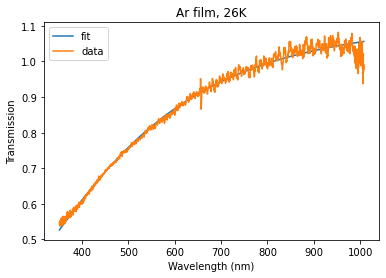

In [49]:
a,b,c = Modelfit(Ar,26,wavl,tr,[1e-7,1e18,1],const=True)
print(a,b,c)

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


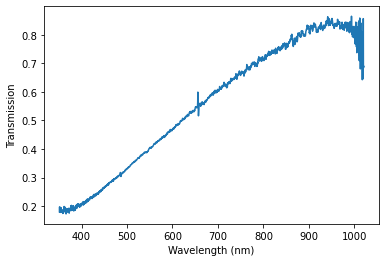

In [58]:
times = ["16-02-53-759","16-01-18-261","14-44-46-840"]
wavl, tr = loadin(Ar,26,190718,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

[1.15954068e-07 3.77701025e+17] [[ 2.73191133e-19 -3.86906727e+06]
 [-3.86906727e+06  5.53041198e+31]] 0.023956535931733833


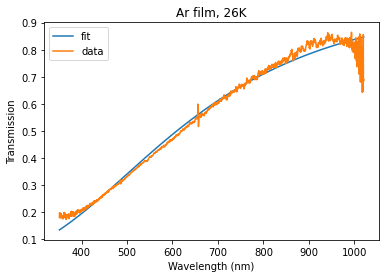

In [238]:
a,b,c = Modelfit(Ar,26,wavl,tr,[1e-7,1e18])
print(a,b,c)

(array([1.29050969e-07, 2.58077122e+17, 1.04510697e+00]),
 array([[ 1.45195266e-18, -1.03819331e+07,  4.34815114e-12],
        [-1.03819331e+07,  7.48996967e+31, -2.99614318e+13],
        [ 4.34815114e-12, -2.99614318e+13,  1.56957356e-05]]),
 0.023107444242748295)

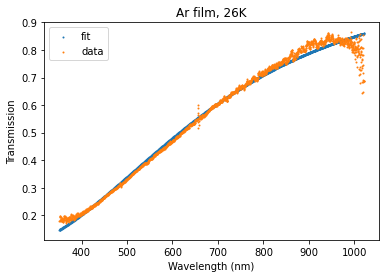

In [59]:
par = Modelfit(Ar,26,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

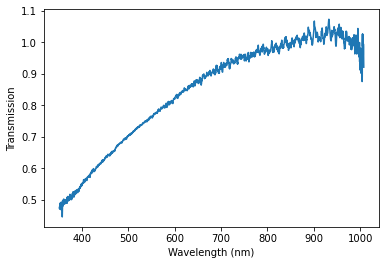

In [53]:
times = ["13-24-03-335","13-23-08-261","11-45-45-042"]
wavl, tr = loadin(Ar,26,190612,times,"(2)")
wavl, tr = redomain([wavl, tr],st=24,end=2000)
display()

[5.03106937e-08 5.44745107e+18] [[ 1.33200712e-18 -7.44397469e+08]
 [-7.44397469e+08  4.16802922e+35]] 0.03733905428402673


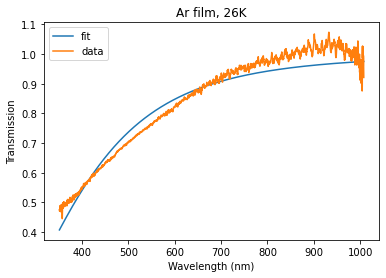

In [240]:
a,b,c = Modelfit(Ar,26,wavl,tr,[1e-7,1e18])
print(a,b,c)

[1.01720893e-07 2.65187156e+17 1.09985975e+00] [[ 1.11802298e-18 -1.12451126e+07  1.67876828e-12]
 [-1.12451126e+07  1.13740186e+32 -1.63676905e+13]
 [ 1.67876828e-12 -1.63676905e+13  3.22077284e-06]] 0.018718707123122333


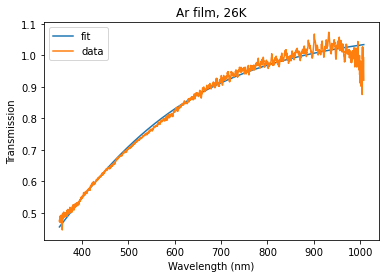

In [54]:
a,b,c = Modelfit(Ar,26,wavl,tr,[1e-7,1e18,1],const=True)
print(a,b,c)

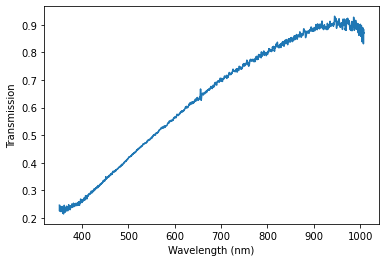

In [60]:
times = ["15-00-14-000","14-58-43-415","13-45-49-884"]
wavl, tr = loadin(Ar,28,190722,times)
wavl, tr = redomain([wavl, tr],st=24,end=2000)
display()

[9.39470251e-08 7.25515019e+17] [[ 2.02765662e-19 -7.13931637e+06]
 [-7.13931637e+06  2.53161857e+32]] 0.02111565982238578


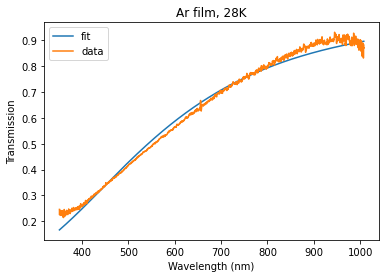

In [209]:
a,b,c = Modelfit(Ar,28,wavl,tr,[1e-7,1e18])
print(a,b,c)

[1.24162851e-07 2.56221411e+17 1.09728813e+00] [[ 4.23215856e-19 -3.14480819e+06  1.21055383e-12]
 [-3.14480819e+06  2.35631393e+31 -8.68099450e+12]
 [ 1.21055383e-12 -8.68099450e+12  4.18831925e-06]] 0.013030042219452823


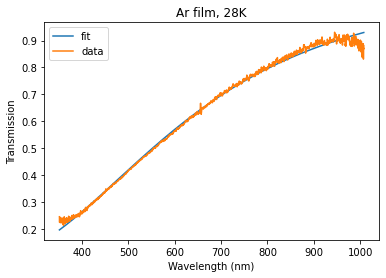

In [52]:
a,b,c = Modelfit(Ar,28,wavl,tr,[1e-7,1e18,1],const=True)
print(a,b,c)

(array([1.24162851e-07, 2.56221411e+17, 1.09728813e+00]),
 array([[ 4.23215856e-19, -3.14480819e+06,  1.21055383e-12],
        [-3.14480819e+06,  2.35631393e+31, -8.68099450e+12],
        [ 1.21055383e-12, -8.68099450e+12,  4.18831925e-06]]),
 0.013030042219452823)

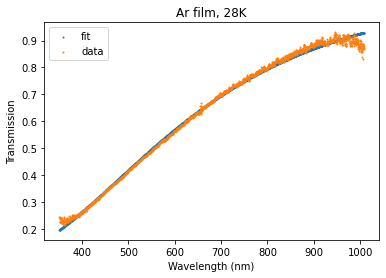

In [61]:
par = Modelfit(Ar,28,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

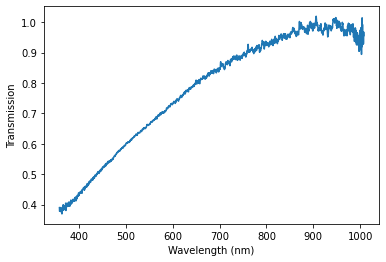

In [62]:
times = ["18-30-47-385","18-29-17-263","16-31-34-337"]
wavl, tr = loadin(Ar,28,190612,times,"(1)")
wavl, tr = redomain([wavl, tr],st=41,end=2000)
display()

[6.55660428e-08 2.17176624e+18] [[ 6.24125490e-19 -1.01470558e+08]
 [-1.01470558e+08  1.65563210e+34]] 0.03127985765268184


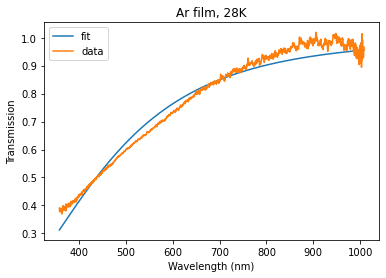

In [242]:
a,b,c = Modelfit(Ar,28,wavl,tr,[1e-7,1e18])
print(a,b,c)

(array([1.07823389e-07, 2.83715437e+17, 1.09929008e+00]),
 array([[ 8.25795214e-19, -8.27241519e+06,  1.58024706e-12],
        [-8.27241519e+06,  8.33660671e+31, -1.53474412e+13],
        [ 1.58024706e-12, -1.53474412e+13,  3.76487938e-06]]),
 0.017137669491325683)

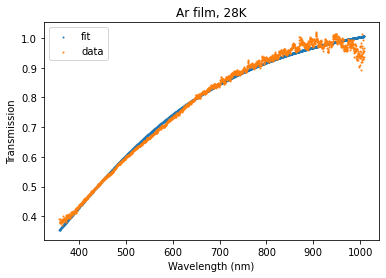

In [63]:
par = Modelfit(Ar,28,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

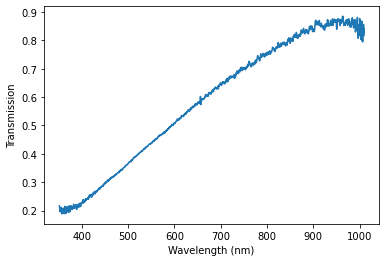

In [64]:
times = ["17-58-51-055","17-57-15-921","16-46-04-963"]
wavl, tr = loadin(Ar,30,190709,times)
wavl, tr = redomain([wavl, tr],24,2005)
display()

[1.05641034e-07 5.05641759e+17] [[ 1.68161279e-19 -3.57653609e+06]
 [-3.57653609e+06  7.66940496e+31]] 0.019022759900437097


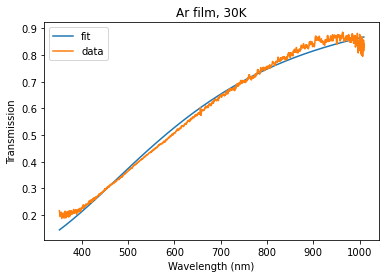

In [65]:
a,b,c = Modelfit(Ar,30,wavl,tr,[1e-7,1e18])
print(a,b,c)

(array([1.31530876e-07, 2.29871550e+17, 1.08983033e+00]),
 array([[ 5.04600814e-19, -3.09312478e+06,  1.58455999e-12],
        [-3.09312478e+06,  1.91402816e+31, -9.35334134e+12],
        [ 1.58455999e-12, -9.35334134e+12,  5.96951665e-06]]),
 0.01379120697546345)

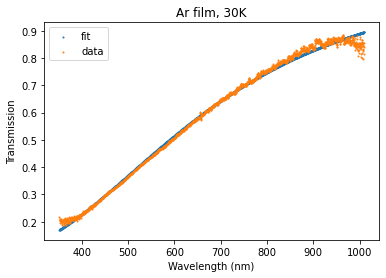

In [66]:
par = Modelfit(Ar,30,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

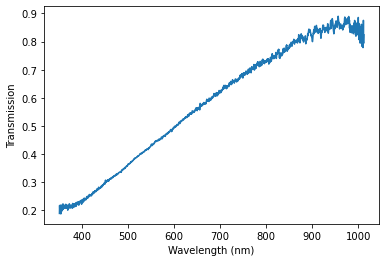

In [67]:
times = ["13-40-27-398","13-38-46-730","12-20-52-807"]
wavl, tr = loadin(Ar,32,190711,times)
wavl, tr = redomain([wavl, tr],24,2015)
display()

[1.14808212e-07 3.64175951e+17] [[ 2.04678428e-19 -2.81173673e+06]
 [-2.81173673e+06  3.89866447e+31]] 0.020520124748400276


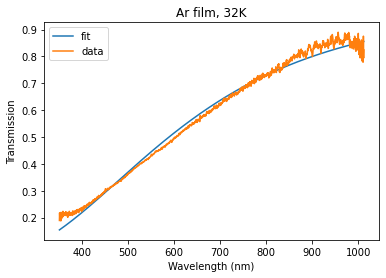

In [68]:
a,b,c = Modelfit(Ar,32,wavl,tr,[1e-7,1e18])
print(a,b,c)

(array([1.45202886e-07, 1.63793290e+17, 1.11052458e+00]),
 array([[ 5.62299140e-19, -2.08552619e+06,  1.92480823e-12],
        [-2.08552619e+06,  7.83534403e+30, -6.82659549e+12],
        [ 1.92480823e-12, -6.82659549e+12,  7.88245277e-06]]),
 0.014404399234395794)

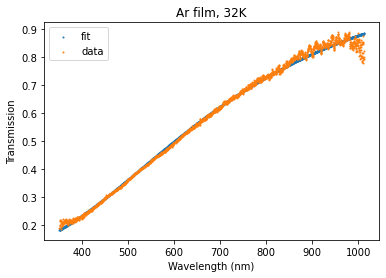

In [69]:
par = Modelfit(Ar,32,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

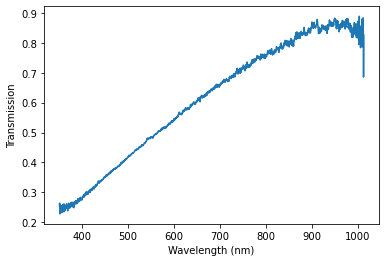

In [70]:
times = ["13-25-04-521","13-23-43-975","12-13-17-637"]
wavl, tr = loadin(Ar,33,190726,times)
wavl, tr = redomain([wavl, tr],24,2020)
display()

[1.20696206e-07 2.57343969e+17] [[ 1.61685807e-19 -1.45076253e+06]
 [-1.45076253e+06  1.31548825e+31]] 0.017502426929767147


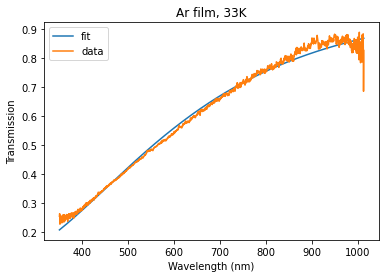

In [71]:
a,b,c = Modelfit(Ar,33,wavl,tr,[1e-7,1e18])
print(a,b,c)

(array([1.37181141e-07, 1.67128234e+17, 1.05141069e+00]),
 array([[ 7.30824245e-19, -3.00159078e+06,  2.00505078e-12],
        [-3.00159078e+06,  1.24662152e+31, -7.89933648e+12],
        [ 2.00505078e-12, -7.89933648e+12,  6.63190428e-06]]),
 0.015753139699620274)

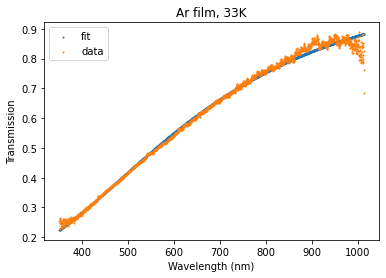

In [72]:
par = Modelfit(Ar,33,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

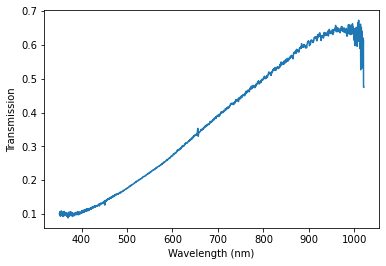

In [73]:
times = ["17-13-20-630","17-11-56-567","15-26-31-621"]
wavl, tr = loadin(Ar,34,190410,times,style=1)
wavl, tr = redomain([wavl, tr],st=24)
display()

[1.62624949e-07 1.67029638e+17] [[ 1.99506801e-19 -8.25135734e+05]
 [-8.25135734e+05  3.45312773e+30]] 0.017330999121894414


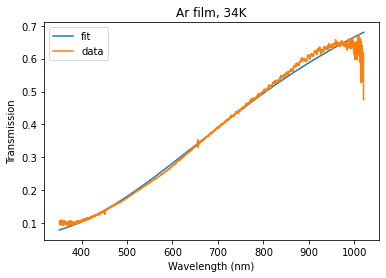

In [74]:
a,b,c = Modelfit(Ar,34,wavl,tr,[1e-7,1e18])
print(a,b,c)

(array([1.56044168e-07, 1.89744252e+17, 9.68517000e-01]),
 array([[ 1.32477276e-18, -5.26839639e+06,  5.25002387e-12],
        [-5.26839639e+06,  2.12411968e+31, -1.99417991e+13],
        [ 5.25002387e-12, -1.99417991e+13,  2.45538165e-05]]),
 0.01717310918555661)

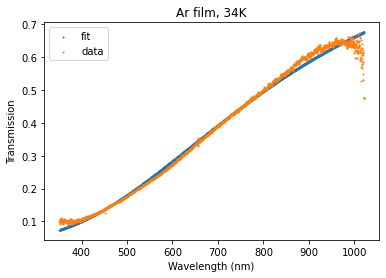

In [75]:
par = Modelfit(Ar,34,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

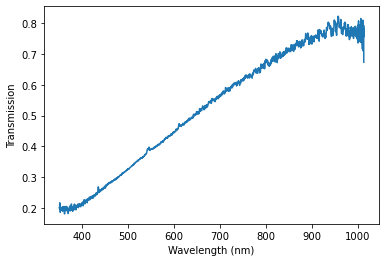

In [76]:
times = ["17-47-23-582","17-45-27-807","16-19-51-437"]
wavl, tr = loadin(Ar,34,190712,times,"(1)",ins="")
wavl, tr = redomain([wavl, tr],24,2020)
display()

(array([1.49524887e-07, 1.50243967e+17, 1.02824969e+00]),
 array([[ 5.70176192e-19, -1.84659287e+06,  1.85996138e-12],
        [-1.84659287e+06,  6.06640798e+30, -5.74439939e+12],
        [ 1.85996138e-12, -5.74439939e+12,  7.25977539e-06]]),
 0.013369514476097003)

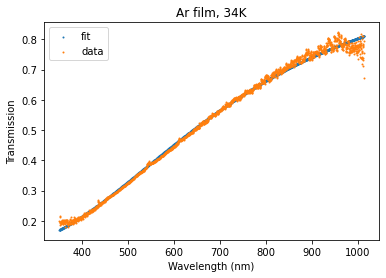

In [77]:
par = Modelfit(Ar,34,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

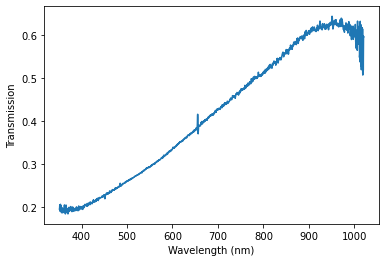

In [78]:
times = ["15-06-15-313","15-04-30-269","13-06-50-910"]
wavl, tr = loadin(Ar,36,190411,times,style=1)
wavl, tr = redomain([wavl, tr],24)
display()

(array([1.89702559e-07, 7.29018114e+16, 9.11481549e-01]),
 array([[ 1.37526805e-18, -1.36144795e+06,  5.05420260e-12],
        [-1.36144795e+06,  1.40562926e+30, -4.56975631e+12],
        [ 5.05420260e-12, -4.56975631e+12,  2.24952413e-05]]),
 0.018319860545253627)

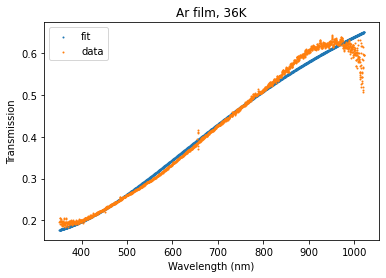

In [79]:
par = Modelfit(Ar,36,wavl,tr,[1e-7,1e18,1],const=True,scat=True)
parlist.append(par)
par

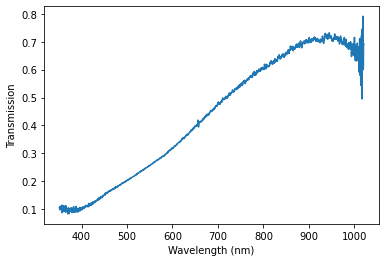

In [130]:
times = ["15-01-13-593","14-58-33-329","13-41-20-318"]
wavl, tr = loadin(Kr,29,190701,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

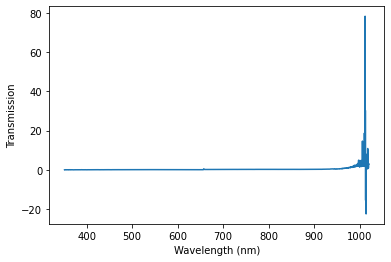

In [179]:
times = ["19-38-03-835","22-21-34-114","19-36-37-441"]
wavl, tr = loadin(Kr,29,190814,times,"(1)",style=2)
wavl, tr = redomain([wavl, tr],st=24)
display()

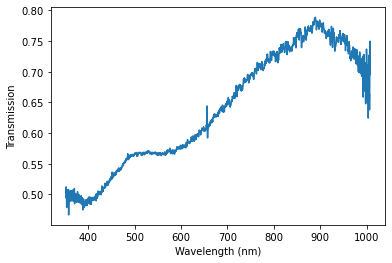

In [55]:
times = ["14-11-36-670","14-10-26-565","12-37-32-839"]
wavl, tr = loadin(Kr,30,190613,times)
wavl, tr = redomain([wavl, tr],24,2000)
display()

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal


[2.39130151e-07 1.83254601e+16] [[ 8.99093811e-19 -2.10409266e+05]
 [-2.10409266e+05  5.10951712e+28]] 0.029241922606184554


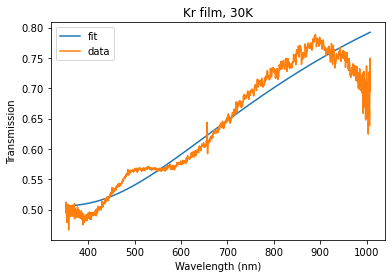

In [254]:
a,b,c = Modelfit(Kr,30,wavl,tr,[1e-8,1e16])
print(a,b,c)

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal


[2.00621976e-07 2.40312888e+16 8.92123453e-01] [[ 5.48124621e-18 -1.39948801e+06  9.94199653e-12]
 [-1.39948801e+06  3.85847781e+29 -2.22559637e+12]
 [ 9.94199653e-12 -2.22559637e+12  2.21382697e-05]] 0.0266809351740483


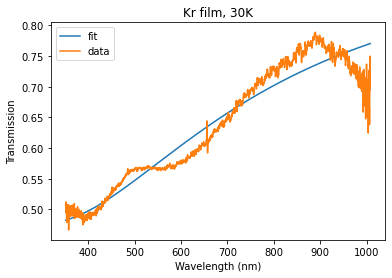

In [57]:
a,b,c = Modelfit(Kr,30,wavl,tr,[1e-9,1e20,1],const=True)
print(a,b,c)

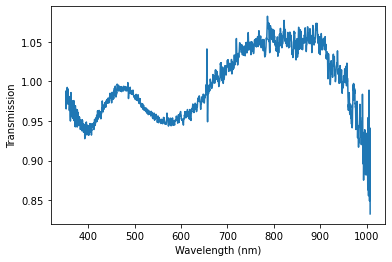

In [58]:
times = ["18-29-59-908","18-28-54-805","17-11-22-311"]
wavl, tr = loadin(Kr,31,190613,times)
wavl, tr = redomain([wavl, tr],24,2000)
display()

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


[3.14537042e-08 4.19906037e+18] [[ 2.53918314e-16 -1.89030897e+11]
 [-1.89030897e+11  1.40776691e+38]] 0.039942134765091106


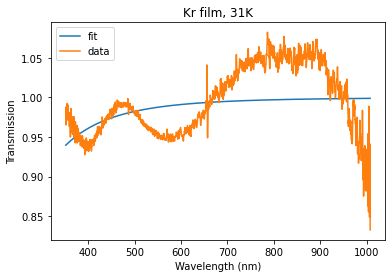

In [257]:
a,b,c = Modelfit(Kr,31,wavl,tr,[1e-8,1e20])
print(a,b,c)

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\

[ 3.53569277e-10 -4.71901195e+20  9.97347784e-01] [[ 1.53483214e-07 -9.04682474e+20 -2.86062609e-08]
 [-9.04682474e+20  1.88134498e+54  3.02740695e+22]
 [-2.86062609e-08  3.02740695e+22  9.57272807e-07]] 0.04335993305783024


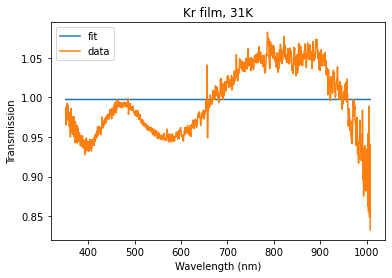

In [62]:
a,b,c = Modelfit(Kr,31,wavl,tr,[1e-8,1e20,1.3],const=True)
print(a,b,c)

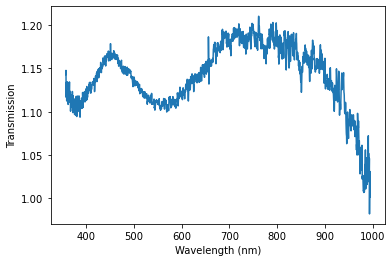

In [73]:
times = ["12-58-10-970","12-56-25-317","11-31-36-619"]
wavl, tr = loadin(Kr,32,190617,times)
wavl, tr = redomain([wavl, tr],41,1950)
display()

In [78]:
a,b,c = Modelfit(Kr,32,wavl,tr,[1e-6,1e18,1],const=True)
print(a,b,c)

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

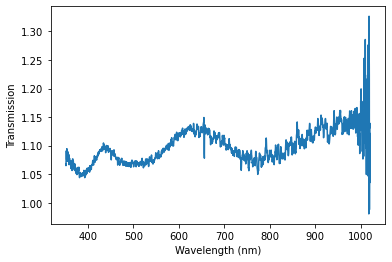

In [169]:
times = ["16-09-19-882","16-08-14-764","14-26-13-175"]
wavl, tr = loadin(Kr,33,190508,times,style=1)
wavl, tr = redomain([wavl, tr],st=24)
display()

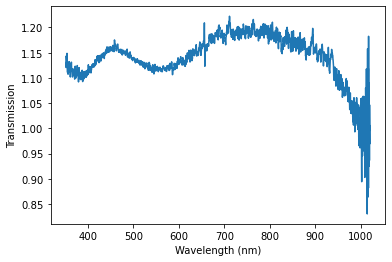

In [136]:
times = ["17-16-58-285","17-14-57-532","15-50-34-247"]
wavl, tr = loadin(Kr,33,190617,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

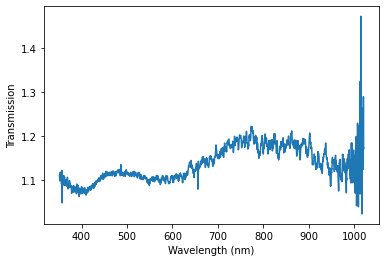

In [137]:
times = ["14-07-14-605","13-59-11-489","12-46-34-566"]
wavl, tr = loadin(Kr,33.5,190624,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

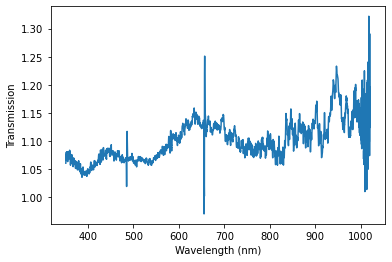

In [182]:
times = ["12-44-53-145","12-45-58-243","11-01-08-986"]
wavl, tr = loadin(Kr,34,190516,times,style=2,ins="_Kr")
wavl, tr = redomain([wavl, tr],st=24)
display()

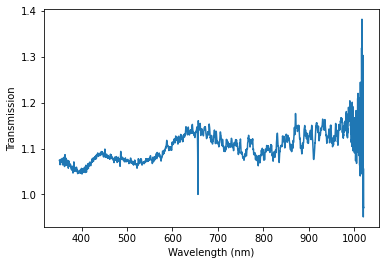

In [140]:
times = ["15-54-32-722","15-49-27-181","13-34-44-237"]
wavl, tr = loadin(Kr,34,190524,times,"(1)","")
wavl, tr = redomain([wavl, tr],st=24)
display()

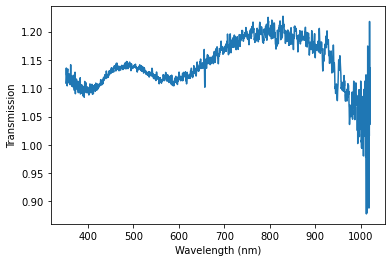

In [141]:
times = ["16-43-55-606","16-35-17-217","14-52-06-376"]
wavl, tr = loadin(Kr,34,190614,times,"(2)")
wavl, tr = redomain([wavl, tr],st=24)
display()

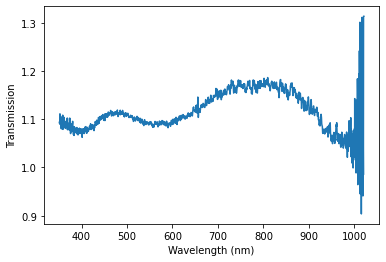

In [143]:
times = ["12-17-27-893","12-23-58-839","11-00-47-152"]
wavl, tr = loadin(Kr,34,190621,times,"(4)")
wavl, tr = redomain([wavl, tr],st=24)
display()

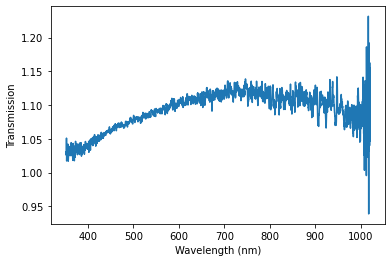

In [144]:
times = ["16-14-56-733","15-46-20-419","14-44-17-744"]
wavl, tr = loadin(Kr,34,190702,times,"(5)")
wavl, tr = redomain([wavl, tr],st=24)
display()

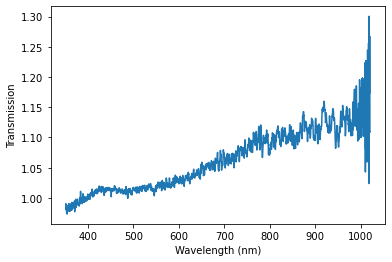

In [183]:
times = ["15-57-19-711","15-56-24-641","14-46-43-243"]
wavl, tr = loadin(Kr,35,190514,times,style=2,ins="_Kr")
wavl, tr = redomain([wavl, tr],st=24)
display()

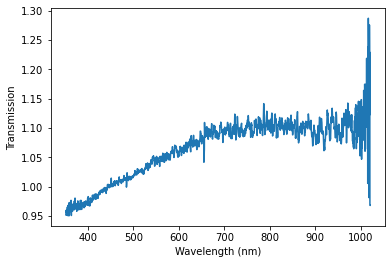

In [184]:
times = ["11-37-33-031","11-36-32-931","10-34-15-384"]
wavl, tr = loadin(Kr,35,190515,times," 2",style=2,ins="_Kr")
wavl, tr = redomain([wavl, tr],st=24)
display()

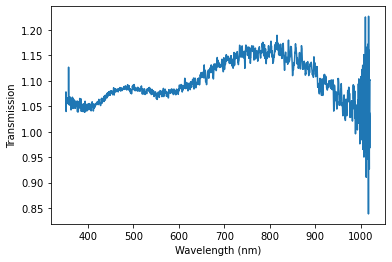

In [145]:
times = ["17-45-57-626","17-43-47-446","16-16-45-073"]
wavl, tr = loadin(Kr,35,190618,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

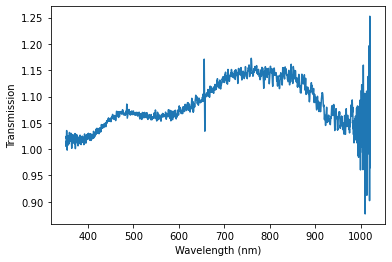

In [146]:
times = ["19-34-58-098","19-33-53-016","18-00-59-699"]
wavl, tr = loadin(Kr,36,190619,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

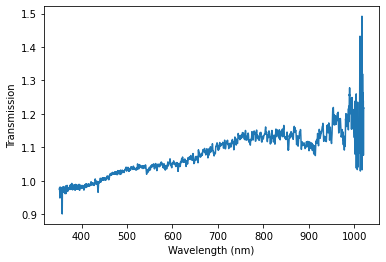

In [147]:
times = ["11-43-12-361","11-48-32-815","10-21-05-426"]
wavl, tr = loadin(Kr,37,190619,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


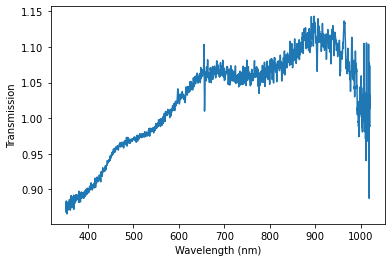

In [173]:
times = ["12-16-48-010","12-18-40-078","10-08-10-395"]
wavl, tr = loadin(Kr,38,190403,times,style=1)
wavl, tr = redomain([wavl, tr],st=24)
display()

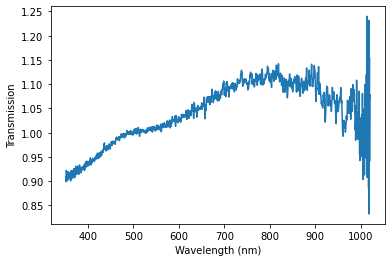

In [148]:
times = ["15-24-26-648","15-20-56-359","13-54-58-629"]
wavl, tr = loadin(Kr,38,190619,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

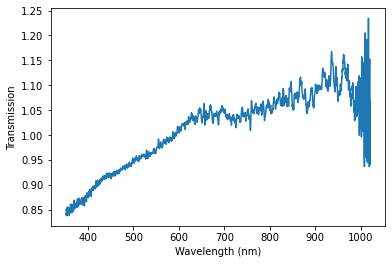

In [149]:
times = ["17-07-13-749","17-06-21-669","15-20-04-731"]
wavl, tr = loadin(Kr,39,190524,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

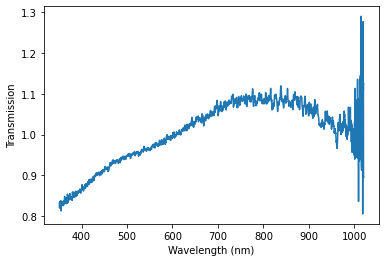

In [150]:
times = ["13-13-47-807","13-09-12-265","11-56-35-612"]
wavl, tr = loadin(Kr,39,190620,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

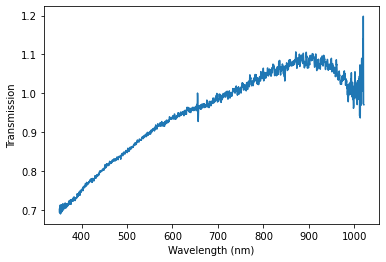

In [175]:
times = ["17-12-27-425","17-13-23-467","15-20-44-856"]
wavl, tr = loadin(Kr,40,190403,times,style=1)
wavl, tr = redomain([wavl, tr],st=24)
display()

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


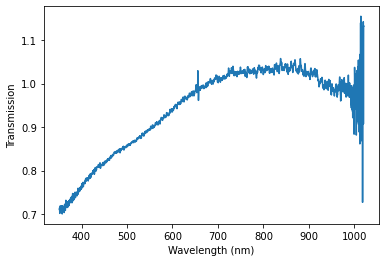

In [151]:
times = ["17-59-57-392","18-06-18-003","16-44-20-208"]
wavl, tr = loadin(Kr,40,190620,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

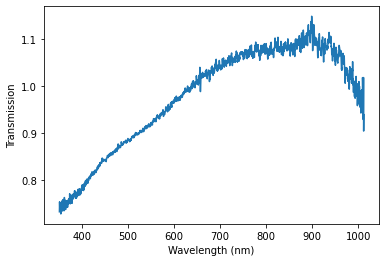

In [81]:
times = ["17-08-35-438","17-05-40-203","15-50-08-816"]
wavl, tr = loadin(Kr,40,190625,times,"(2)")
wavl, tr = redomain([wavl, tr],24,2015)
display()

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


[8.77938504e-08 2.41664090e+17 1.11122713e+00] [[ 6.32050182e-18 -7.07788874e+07  4.96315150e-12]
 [-7.07788874e+07  7.95931366e+32 -5.39884941e+13]
 [ 4.96315150e-12 -5.39884941e+13  5.27522994e-06]] 0.031307401571334006


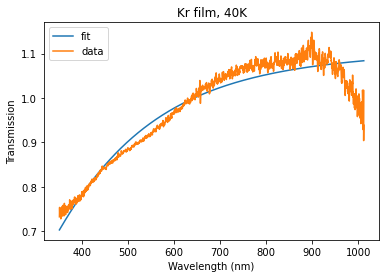

In [82]:
a,b,c = Modelfit(Kr,40,wavl,tr,[1e-7,1e18,1],const=True)
print(a,b,c)

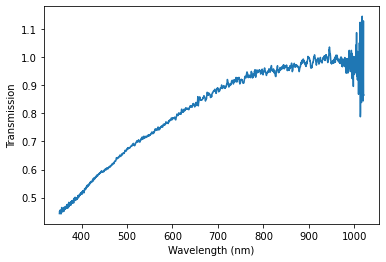

In [153]:
times = ["12-34-07-442","12-32-43-338","10-44-41-930"]
wavl, tr = loadin(Kr,41,190524,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

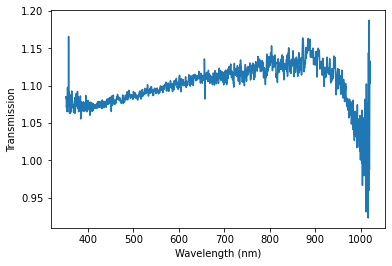

In [154]:
times = ["13-59-47-628","13-58-47-544","12-38-05-094"]
wavl, tr = loadin(Kr,41,190626,times," dirty")
wavl, tr = redomain([wavl, tr],st=24)
display()

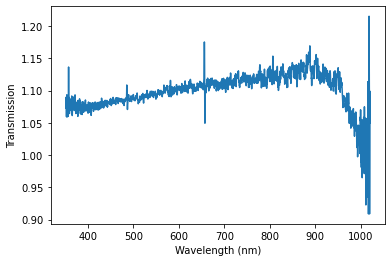

In [155]:
times = ["17-59-18-455","17-56-48-252","16-41-36-406"]
wavl, tr = loadin(Kr,41,190626,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

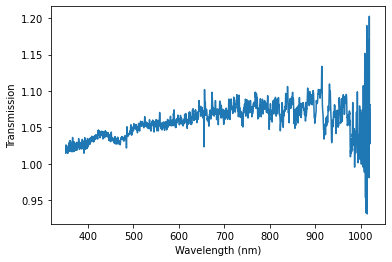

In [176]:
times = ["11-35-23-834","11-32-58-640","09-51-09-530"]
wavl, tr = loadin(Kr,42,190508,times,style=1)
wavl, tr = redomain([wavl, tr],st=24)
display()

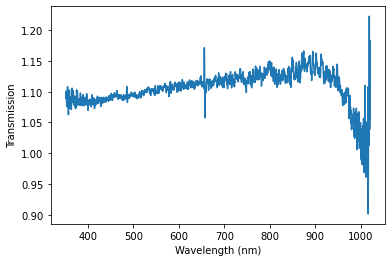

In [158]:
times = ["11-09-12-172","11-08-17-099","09-52-55-456"]
wavl, tr = loadin(Kr,42,190627,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

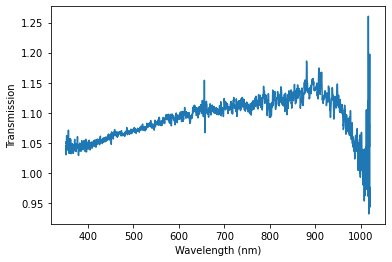

In [159]:
times = ["15-14-28-745","15-12-53-605","13-49-21-140"]
wavl, tr = loadin(Kr,43,190627,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

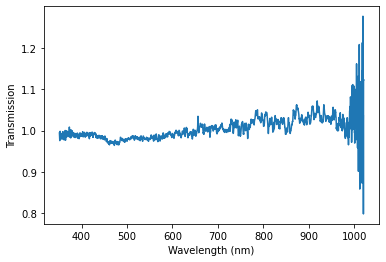

In [160]:
times = ["17-52-36-052","17-51-11-935","15-46-05-147"]
wavl, tr = loadin(Kr,44,190524,times)
wavl, tr = redomain([wavl, tr],st=24)
display()

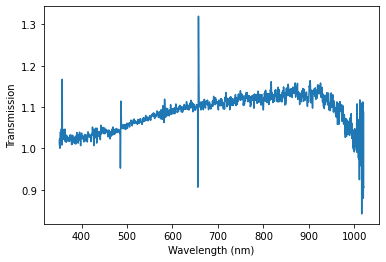

In [161]:
times = ["16-12-54-675","16-09-49-414","14-51-32-423"]
wavl, tr = loadin(Kr,44,190628,times,"(1)")
wavl, tr = redomain([wavl, tr],st=24)
display()

In [80]:
pars = parlist.copy()
pars

[(array([1.75799804e-07, 1.67396301e+17, 1.07759484e+00]),
  array([[ 2.78123116e-19, -8.13596152e+05,  1.61658544e-12],
         [-8.13596152e+05,  2.42379154e+30, -4.48321436e+12],
         [ 1.61658544e-12, -4.48321436e+12,  1.09884436e-05]]),
  0.015432317095281228),
 (array([1.08949767e-07, 1.76516862e+17, 1.11969546e+00]),
  array([[ 9.00235609e-19, -5.41376253e+06,  1.25787855e-12],
         [-5.41376253e+06,  3.27639851e+31, -7.32246777e+12],
         [ 1.25787855e-12, -7.32246777e+12,  2.21348412e-06]]),
  0.015006678268960868),
 (array([1.29050969e-07, 2.58077122e+17, 1.04510697e+00]),
  array([[ 1.45195266e-18, -1.03819331e+07,  4.34815114e-12],
         [-1.03819331e+07,  7.48996967e+31, -2.99614318e+13],
         [ 4.34815114e-12, -2.99614318e+13,  1.56957356e-05]]),
  0.023107444242748295),
 (array([1.24162851e-07, 2.56221411e+17, 1.09728813e+00]),
  array([[ 4.23215856e-19, -3.14480819e+06,  1.21055383e-12],
         [-3.14480819e+06,  2.35631393e+31, -8.68099450e+12],
 

In [97]:
pars=np.array(pars)
paras = np.stack(pars[:,0])
paras

array([[1.75799804e-07, 1.67396301e+17, 1.07759484e+00],
       [1.08949767e-07, 1.76516862e+17, 1.11969546e+00],
       [1.29050969e-07, 2.58077122e+17, 1.04510697e+00],
       [1.24162851e-07, 2.56221411e+17, 1.09728813e+00],
       [1.07823389e-07, 2.83715437e+17, 1.09929008e+00],
       [1.31530876e-07, 2.29871550e+17, 1.08983033e+00],
       [1.45202886e-07, 1.63793290e+17, 1.11052458e+00],
       [1.37181141e-07, 1.67128234e+17, 1.05141069e+00],
       [1.56044168e-07, 1.89744252e+17, 9.68517000e-01],
       [1.49524887e-07, 1.50243967e+17, 1.02824969e+00],
       [1.89702559e-07, 7.29018114e+16, 9.11481549e-01]])

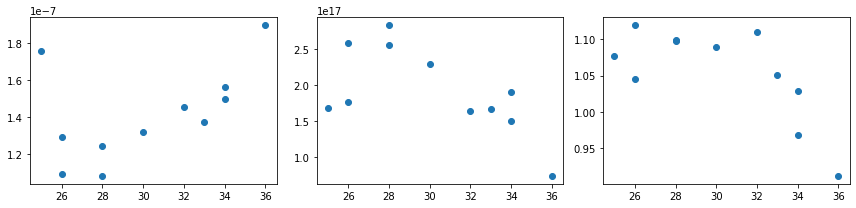

In [105]:
Temps = [25,26,26,28,28,30,32,33,34,34,36]

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(Temps,paras[:,0])
plt.subplot(1,3,2)
plt.scatter(Temps,paras[:,1])
plt.subplot(1,3,3)
plt.scatter(Temps,paras[:,2])
plt.tight_layout()